## Contents

1. scratchpad for future post processing.
2. some step by step stuff
3. one cell that does all the stuff in 2
    * creates 1 file in predictions folder
4. some smoothing stuff
5. one cell that does the smoothing stuff in 4
    * creates 2 files in predictions folder

### scratchpad for future stuff (ignore)

* Instead of the POS value being a flat 100 or 0, it could be ((actual POS+100)/2). But just divide by 2 for the trough. This would maintain a higher range while tying the values to the prediction.

e.g. instead of this

    for i in range(len(peaks)):
        new_json['actions'].append({'pos': 100, 'at': int(ats[peaks[i]])})
    for i in range(len(troughs)):
        new_json['actions'].append({'pos': 0, 'at': int(ats[troughs[i]])})

it would be this

    for i in range(len(peaks)):
        new_json['actions'].append({'pos': int(pos[peaks[i]] + 100) //2, 'at': int(ats[peaks[i]])})
    for i in range(len(troughs)):
        new_json['actions'].append({'pos': int(pos[peaks[i]]) //2, 'at': int(ats[troughs[i]])})


* Or, intermediate frames could be added with their value relative to the peak.
* Or wave finding functions could be used to generate smoothed intermediate values etc.
* Or, the values of the intermediate frames could be preserved and just normalized between the peaks.
* And anomaly detection could find missed strokes and allow manual, or single button press to fix/accept a recommendation.
* And for scenes that it’s very bad at, could be added to the dataset for further tuning of the model and reducing the need for post processing.

## Step by step stuff

### Imports!

In [140]:
from glob import glob
import os
import json
from scipy.signal import find_peaks, find_peaks_cwt
import matplotlib.pyplot as plt
import numpy as np

### Load the latest funscript file from predictions

In [141]:
files = glob('predictions/*.funscript')
files = [file for file in files if 'postprocessed' not in file]
file = files[-1]
print(file)
json_data = json.load(open(file))
actions = json_data['actions']
pos = []
for action in actions:
    pos.append(action['pos'])
pos = np.array(pos)

predictions/milfvr-gobble-squabble-180_180x180_3dh_LR.mp4.20231125-012514.funscript


In [142]:
print("FILE INDEXES IF YOU WANT TO CHANGE WHICH FILE TO POSTPROCESS LATER")
files = glob('predictions/*.funscript')
files = [file for file in files if 'postprocessed' not in file]
for i in range(len(files)):
    print("Positive index:", i, "       Negative index:", -len(files)+i, "       File:", files[i])

FILE INDEXES IF YOU WANT TO CHANGE WHICH FILE TO POSTPROCESS LATER
Positive index: 0        Negative index: -4        File: predictions/SLR_TmwVRNet_Sexy Housekeeper Gets A Creampie_1920p_35311_LR_180.mp4.20231123-160139.funscript
Positive index: 1        Negative index: -3        File: predictions/milfvr-gobble-squabble-180_180x180_3dh_LR.mp4.poi.20231125-012514.funscript
Positive index: 2        Negative index: -2        File: predictions/milfvr-gobble-squabble-180_180x180_3dh_LR.mp4.crop.20231125-012514.funscript
Positive index: 3        Negative index: -1        File: predictions/milfvr-gobble-squabble-180_180x180_3dh_LR.mp4.20231125-012514.funscript


### Visualize distance and prominence variable impact on output

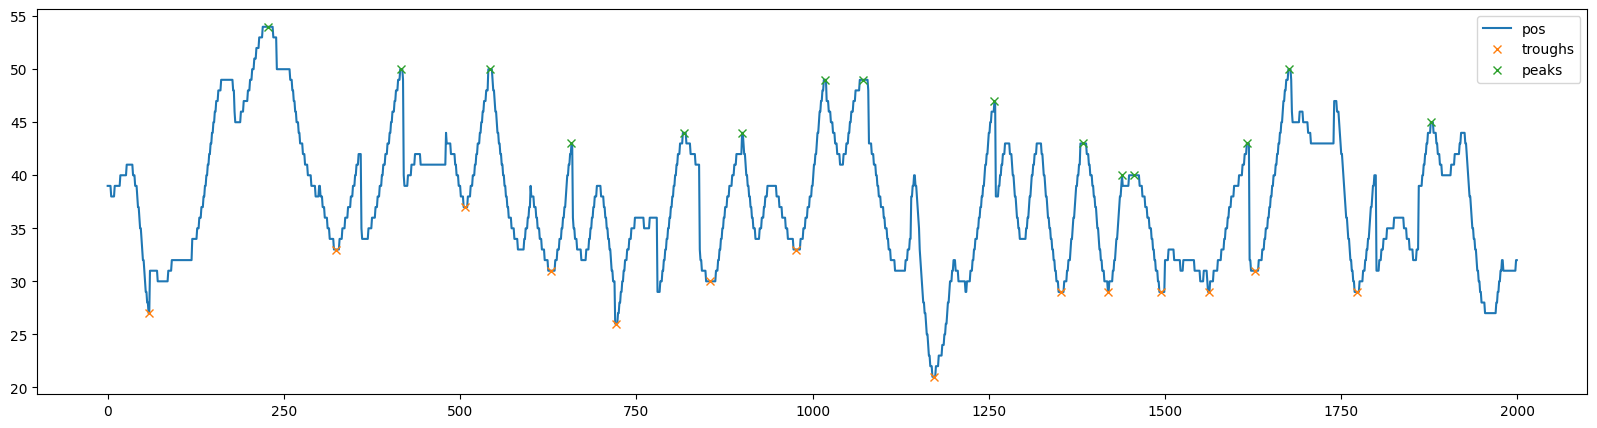

In [143]:
start = 0
finish = 2000
distance = 10
prominence = 10

peaks, _ = find_peaks(pos[start:finish], distance=distance, prominence=prominence)
pos_inverted = 100 - pos
troughs, _ = find_peaks(pos_inverted[start:finish], distance=distance, prominence=prominence)
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(pos[start:finish])
plt.plot(troughs, pos[troughs], 'x')
plt.plot(peaks, pos[peaks], 'x')
plt.legend(['pos', 'troughs', 'peaks'])
plt.show()

## one cell that does all the stuff in 2
### Put it all together and make a new funscript file from the peaks

predictions/milfvr-gobble-squabble-180_180x180_3dh_LR.mp4.poi.20231125-012514.funscript


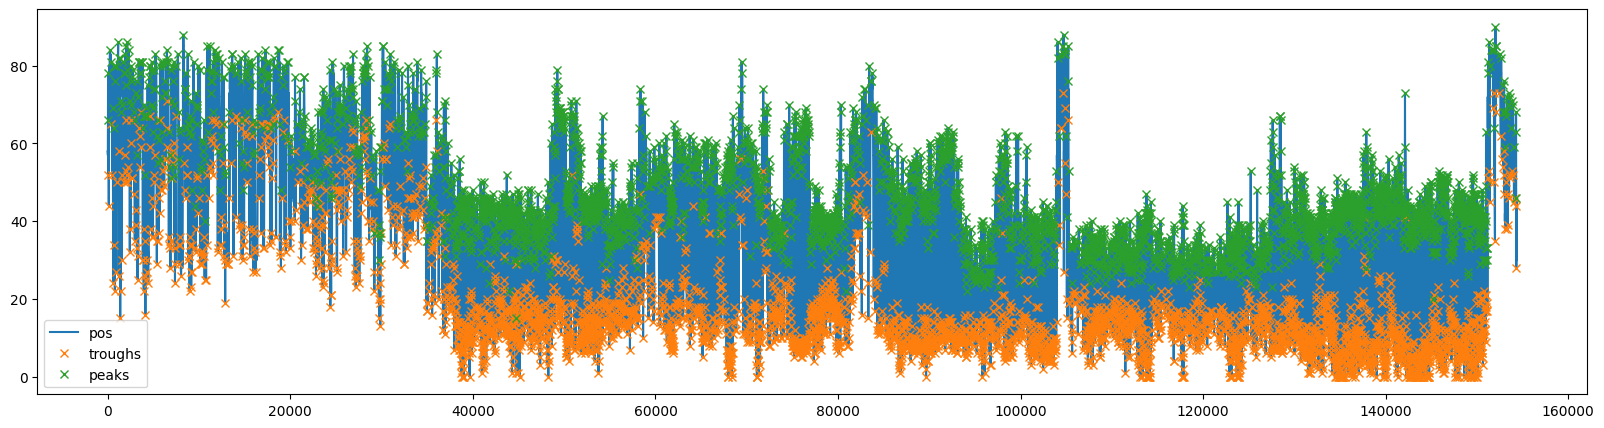

In [144]:
WHICH_FILE = -3  # -1 is the last file, -2 is the second last file, etc.


from glob import glob
import os
import json
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np

start = 0
finish = -1
distance = 10
prominence = 10

files = glob('predictions/*.funscript')
files = [file for file in files if 'postprocessed' not in file]
file = files[WHICH_FILE]
print(file)
json_data = json.load(open(file))
actions = json_data['actions']
pos = []
ats = []
for action in actions:
    pos.append(action['pos'])
    ats.append(action['at'])
pos = np.array(pos)
ats = np.array(ats)

peaks, _ = find_peaks(pos[start:finish], distance=distance, prominence=prominence)
pos_inverted = 100 - pos
troughs, _ = find_peaks(pos_inverted[start:finish], distance=distance, prominence=prominence)
plt.plot(pos[start:finish])
plt.plot(troughs, pos[troughs], 'x')
plt.plot(peaks, pos[peaks], 'x')
plt.legend(['pos', 'troughs', 'peaks'])
plt.show()

new_json = {'actions': []}
for i in range(len(peaks)):
    new_json['actions'].append({'pos': 100, 'at': int(ats[peaks[i]])})

for i in range(len(troughs)):
    new_json['actions'].append({'pos': 0, 'at': int(ats[troughs[i]])})

new_json['actions'] = sorted(new_json['actions'], key=lambda k: k['at'])
new_json['version'] = 1
new_json['inverted'] = False
new_json['range'] = 100

newfile = file.replace('.funscript', '_postprocessed.funscript') 
with open(newfile, 'w') as outfile:
    json.dump(new_json, outfile, indent=4)

## some smoothing stuff

### Peak to Peak normalization

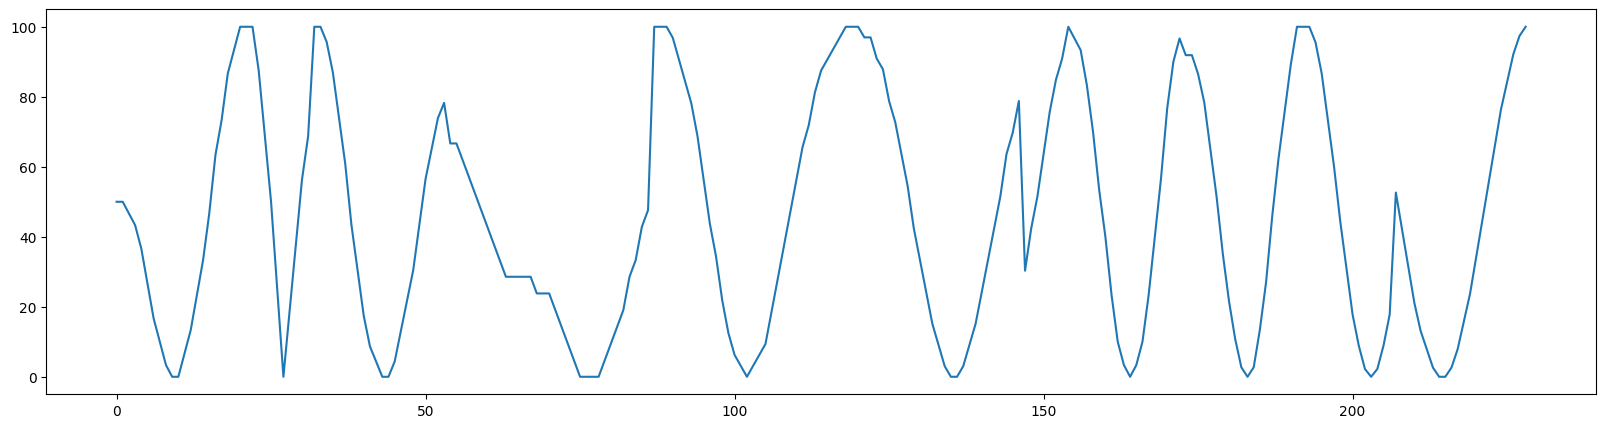

In [145]:
new_pos = []
new_pos.extend(pos[:peaks[0]])
for i in range(len(peaks) - 1):
    pos_peak_to_peak = pos[peaks[i]:peaks[i+1]]
    # normalize from 0 to 100
    pos_peak_to_peak = np.array(pos_peak_to_peak)
    pos_peak_to_peak = (pos_peak_to_peak - pos_peak_to_peak.min()) / (pos_peak_to_peak.max() - pos_peak_to_peak.min()) * 100
    new_pos.extend(pos_peak_to_peak)
new_pos.extend(pos[peaks[-1]:])
new_pos = np.array(new_pos)
plt.plot(new_pos[peaks[750]:peaks[760]])
plt.show()


### Savgol filtering

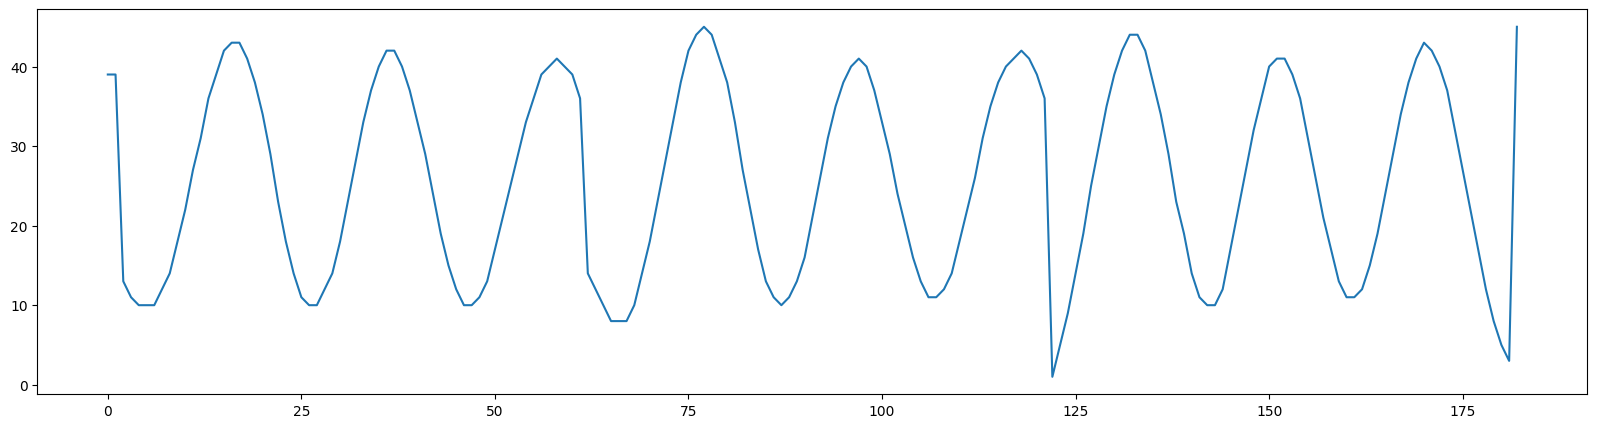

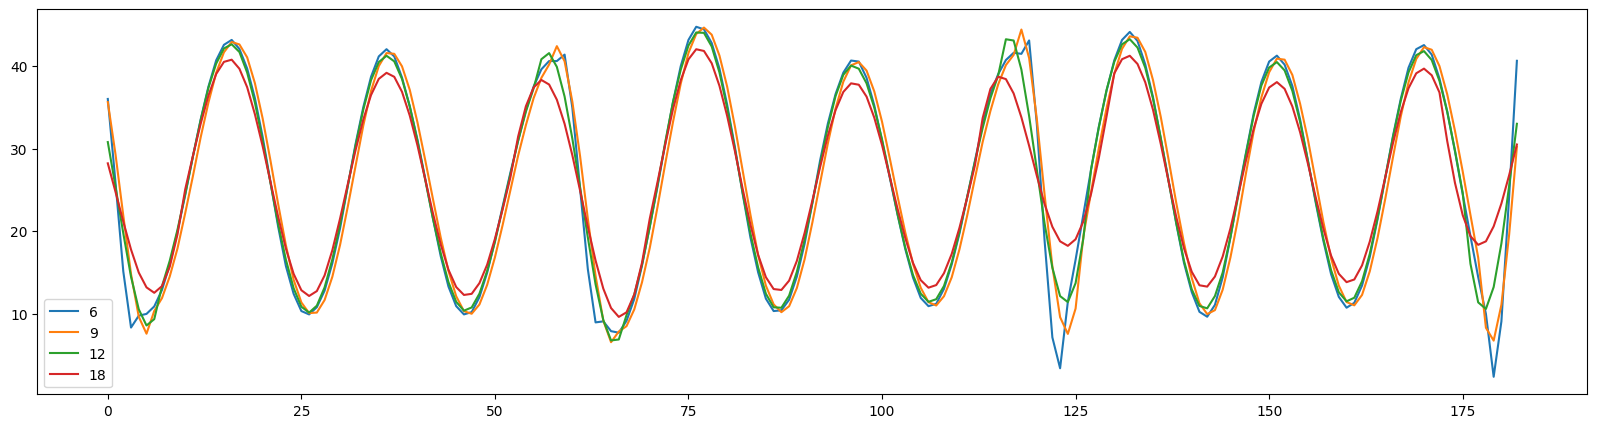

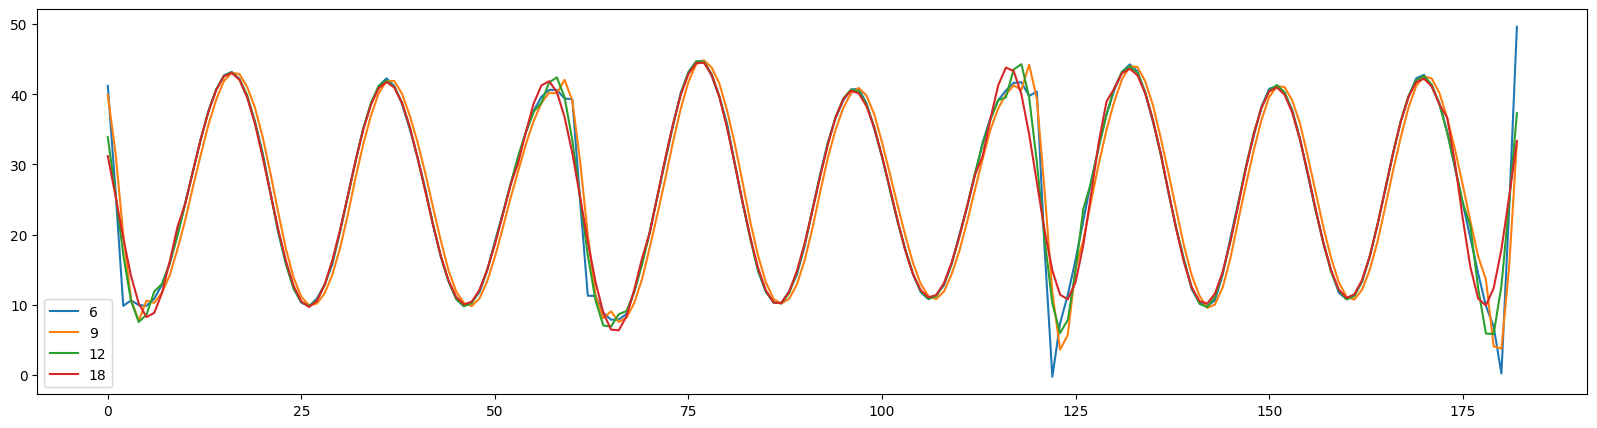

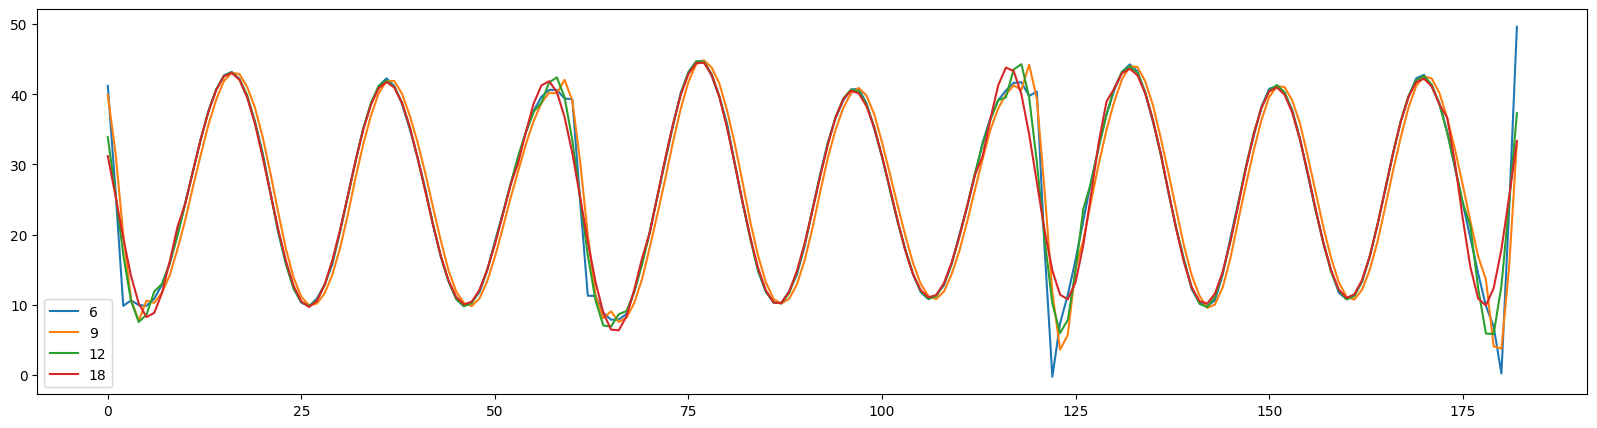

In [147]:
start = peaks[720]
finish = peaks[730]
from scipy.signal import savgol_filter
# change graph size
poly = 3
plt.rcParams['figure.figsize'] = [20, 5]
smoothed_pos = pos.copy()
plt.plot(smoothed_pos[start:finish])
plt.show()
smoothed_pos = savgol_filter(smoothed_pos, 6, poly)
plt.plot(smoothed_pos[start:finish])
smoothed_pos = pos.copy()
smoothed_pos = savgol_filter(smoothed_pos, 9, poly)
plt.plot(smoothed_pos[start:finish])
smoothed_pos = pos.copy()
smoothed_pos = savgol_filter(smoothed_pos, 12, poly)
plt.plot(smoothed_pos[start:finish])
smoothed_pos = pos.copy()
smoothed_pos = savgol_filter(smoothed_pos, 18, poly)
plt.plot(smoothed_pos[start:finish])
plt.legend(['6', '9', '12', '18'])
plt.show()


poly = 4
smoothed_pos = pos.copy()
smoothed_pos = savgol_filter(smoothed_pos, 6, poly)
plt.plot(smoothed_pos[start:finish])
smoothed_pos = pos.copy()
smoothed_pos = savgol_filter(smoothed_pos, 9, poly)
plt.plot(smoothed_pos[start:finish])
smoothed_pos = pos.copy()
smoothed_pos = savgol_filter(smoothed_pos, 12, poly)
plt.plot(smoothed_pos[start:finish])
smoothed_pos = pos.copy()
smoothed_pos = savgol_filter(smoothed_pos, 18, poly)
plt.plot(smoothed_pos[start:finish])
plt.legend(['6', '9', '12', '18'])
plt.show()

poly = 5
smoothed_pos = pos.copy()
smoothed_pos = savgol_filter(smoothed_pos, 6, poly)
plt.plot(smoothed_pos[start:finish])
smoothed_pos = pos.copy()
smoothed_pos = savgol_filter(smoothed_pos, 9, poly)
plt.plot(smoothed_pos[start:finish])
smoothed_pos = pos.copy()
smoothed_pos = savgol_filter(smoothed_pos, 12, poly)
plt.plot(smoothed_pos[start:finish])
smoothed_pos = pos.copy()
smoothed_pos = savgol_filter(smoothed_pos, 18, poly)
plt.plot(smoothed_pos[start:finish])
plt.legend(['6', '9', '12', '18'])
plt.show()

## one cell that does the smoothing stuff tested in heading 4

predictions/milfvr-gobble-squabble-180_180x180_3dh_LR.mp4.poi.20231125-012514.funscript
original prediction form


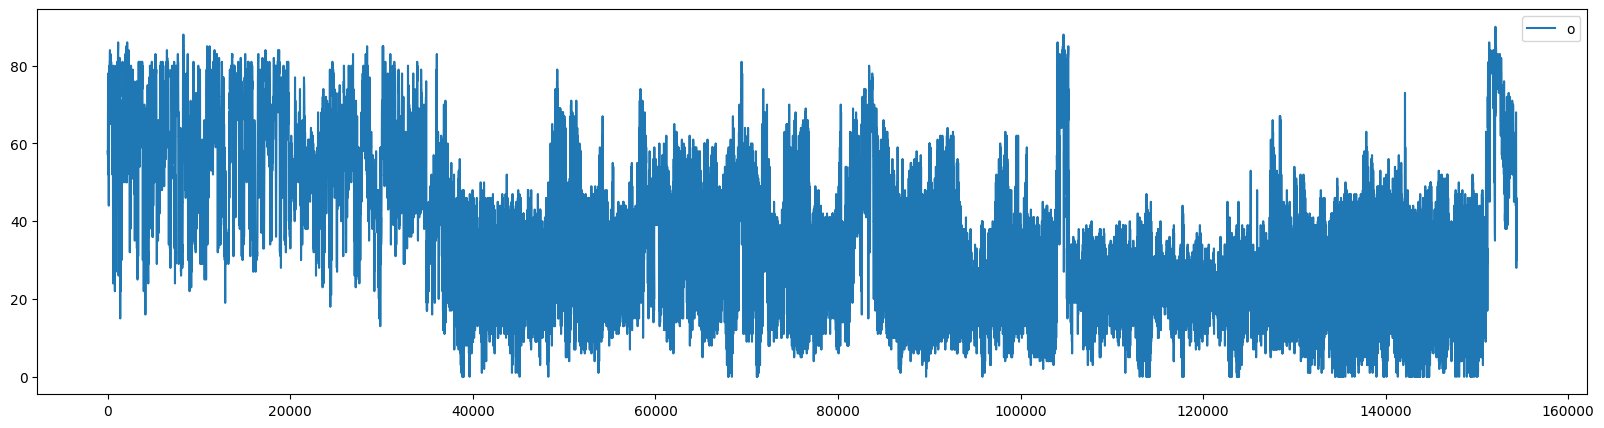

smoothed prediction form


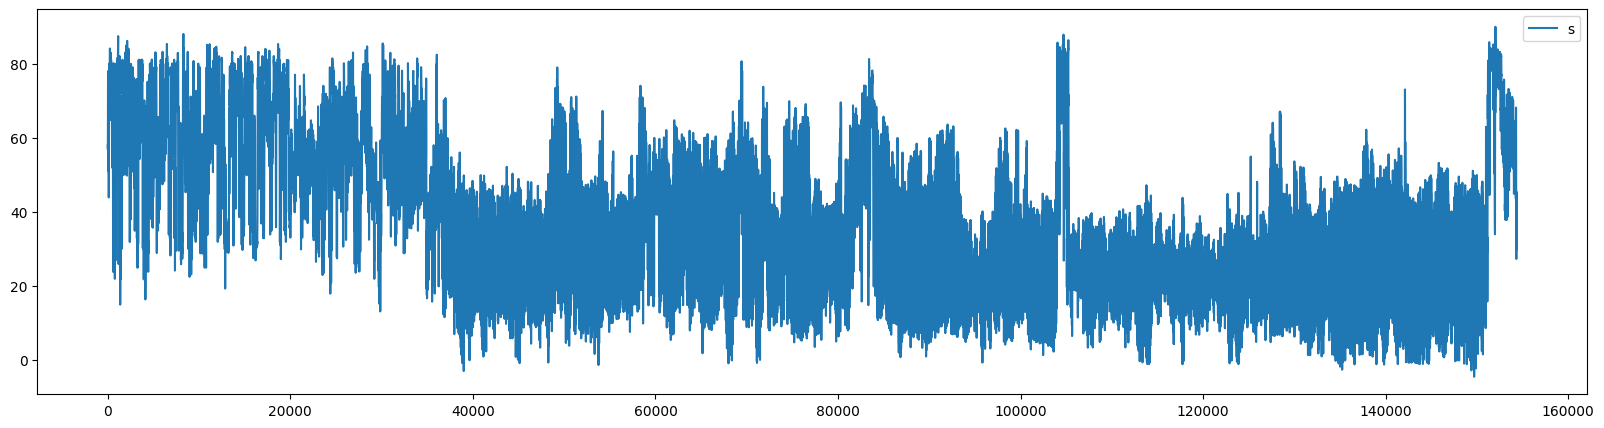

original peaks and troughs


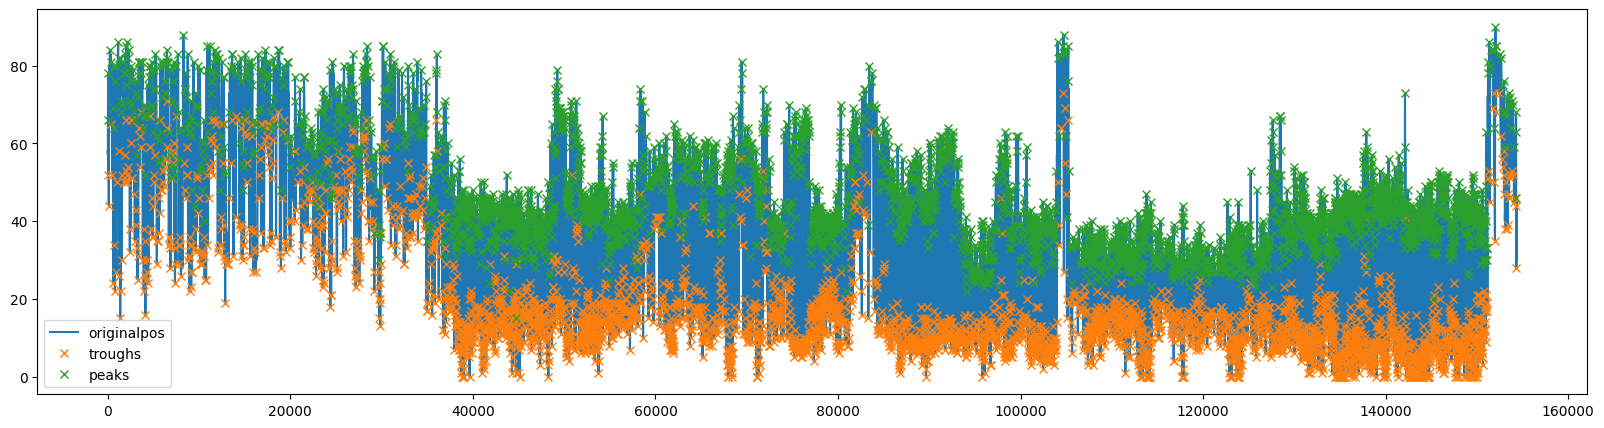

smoothed peaks and troughs


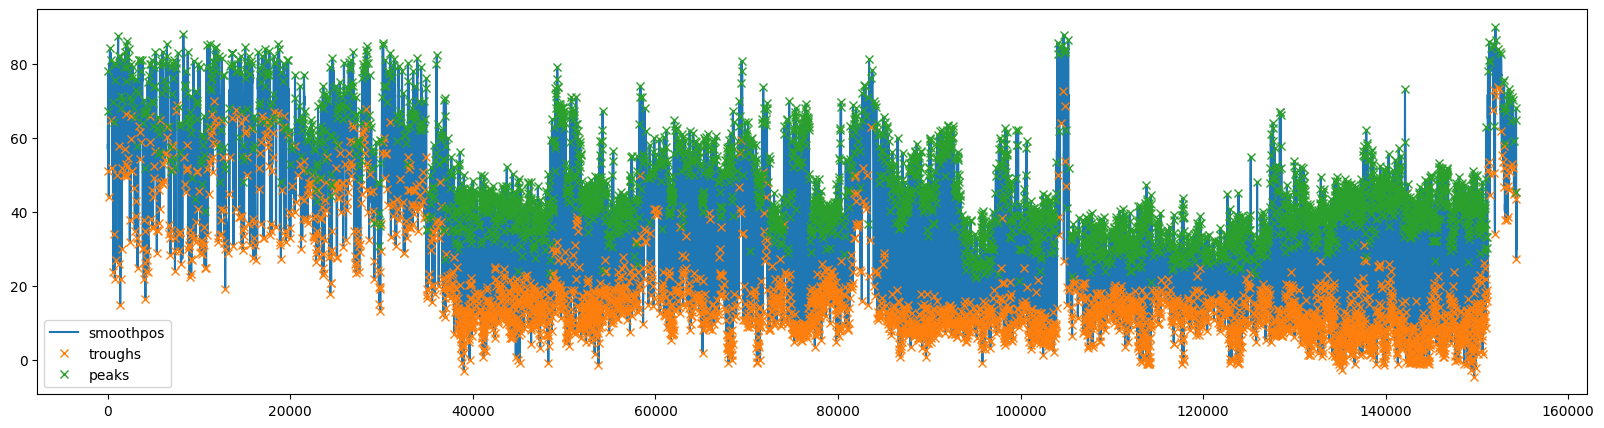

normalized peaks and troughs of smoothed


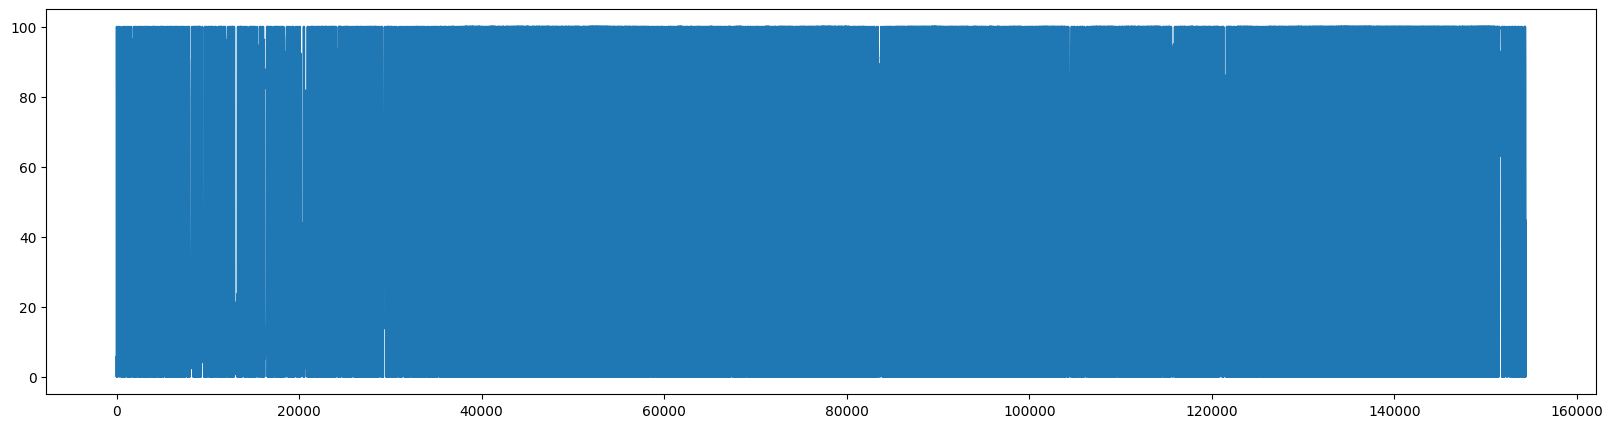

smoothed normalized peaks and troughs of smoothed


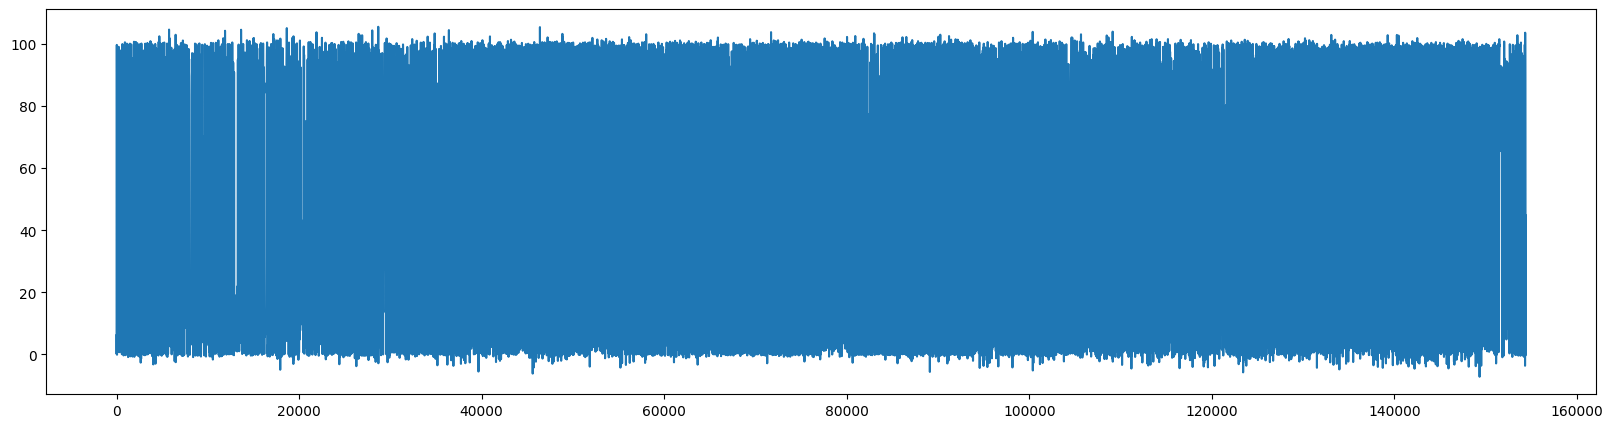

new peaks and troughs


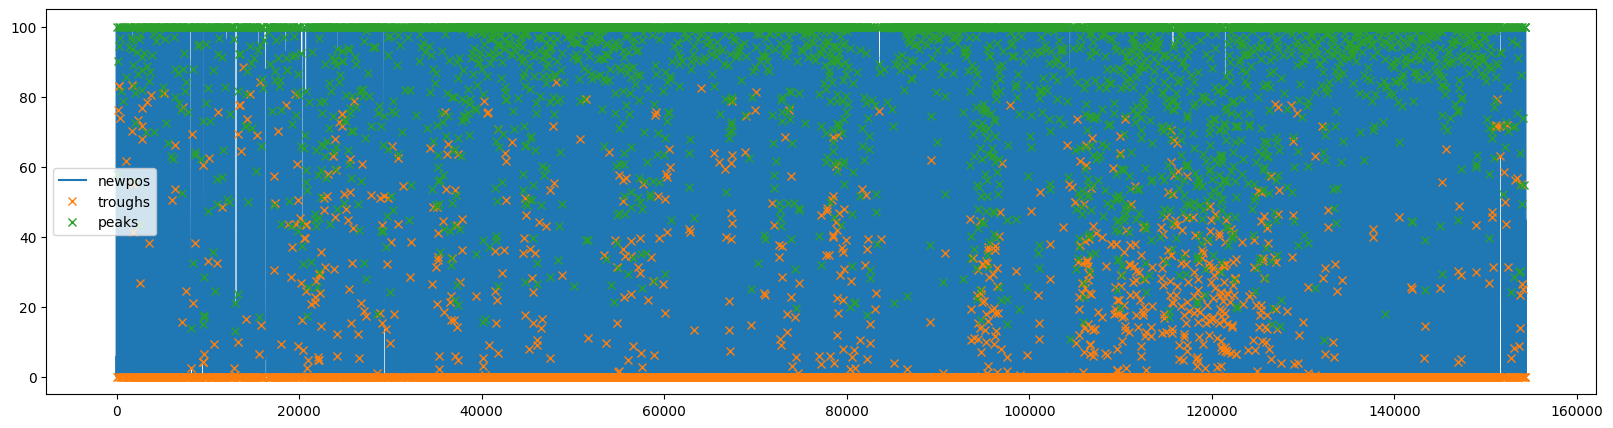

In [148]:
WHICH_FILE = -3  # -1 is the last file, -2 is the second last file, etc.

from glob import glob
import os
import json
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# window 12 seems to be a good figure, also poly 4
poly = 4
window = 12

start = 0
finish = -1
distance = 10
prominence = 10

plt.rcParams['figure.figsize'] = [20, 5]

files = glob('predictions/*.funscript')
files = [file for file in files if 'postprocessed' not in file]
file = files[WHICH_FILE]
print(file)

json_data = json.load(open(file))
actions = json_data['actions']
pos = []
ats = []
for action in actions:
    pos.append(action['pos'])
    ats.append(action['at'])
pos = np.array(pos)
ats = np.array(ats)
smoothed_pos = pos.copy()
plt.plot(pos[start:finish])
plt.legend("original")
print("original prediction form")
plt.show()
smoothed_pos = savgol_filter(smoothed_pos, window, poly)

plt.plot(smoothed_pos[start:finish])
plt.legend('smoothed')
print("smoothed prediction form")
plt.show()





peaks, _ = find_peaks(pos[start:finish], distance=distance, prominence=prominence)
pos_inverted = 100 - pos.copy()
troughs, _ = find_peaks(pos_inverted[start:finish], distance=distance, prominence=prominence)
plt.plot(pos[start:finish])
plt.plot(troughs, pos[start:finish][troughs], 'x')
plt.plot(peaks, pos[start:finish][peaks], 'x')
plt.legend(['originalpos', 'troughs', 'peaks']),
print("original peaks and troughs")
plt.show()


peaks, _ = find_peaks(smoothed_pos[start:finish], distance=distance, prominence=prominence)
pos_inverted = 100 - smoothed_pos.copy()
troughs, _ = find_peaks(pos_inverted[start:finish], distance=distance, prominence=prominence)
plt.plot(smoothed_pos[start:finish])
plt.plot(troughs, smoothed_pos[start:finish][troughs], 'x')
plt.plot(peaks, smoothed_pos[start:finish][peaks], 'x')
plt.legend(['smoothpos', 'troughs', 'peaks'])
print("smoothed peaks and troughs")
plt.show()

new_pos = []
first_set = smoothed_pos[start:finish][:peaks[0]]
first_set = np.array(first_set)
first_set = (first_set - first_set.min()) / (first_set.max() - first_set.min()) * 100
new_pos.extend(first_set)

for i in range(len(peaks) - 1):
    pos_peak_to_peak = smoothed_pos[start:finish][peaks[i]:peaks[i+1]]
    # normalize from 0 to 100
    pos_peak_to_peak = np.array(pos_peak_to_peak)
    pos_peak_to_peak = (pos_peak_to_peak - pos_peak_to_peak.min()) / (pos_peak_to_peak.max() - pos_peak_to_peak.min()) * 100
    new_pos.extend(pos_peak_to_peak)
last_set = smoothed_pos[start:finish][peaks[-1]:]
last_set = np.array(last_set)
last_set = (last_set - last_set.min()) / (last_set.max() - last_set.min()) * 100
new_pos.extend(last_set)
new_pos = np.array(new_pos)
plt.plot(new_pos)
print("normalized peaks and troughs of smoothed")
plt.show()

smoothed_new_pos = new_pos.copy()
smoothed_new_pos = savgol_filter(smoothed_new_pos, window*2, poly)
plt.plot(smoothed_new_pos)
print("smoothed normalized peaks and troughs of smoothed")
plt.show()


peaks, _ = find_peaks(new_pos, distance=distance, prominence=prominence)
pos_inverted = 100 - new_pos.copy()
troughs, _ = find_peaks(pos_inverted, distance=distance, prominence=prominence)
plt.plot(new_pos)
plt.plot(troughs, new_pos[troughs], 'x')
plt.plot(peaks, new_pos[peaks], 'x')
plt.legend(['newpos', 'troughs', 'peaks'])
print("new peaks and troughs")
plt.show()




new_json = {'actions': []}
for i in range(len(peaks)):
    new_json['actions'].append({'pos': 100, 'at': int(ats[peaks[i]])})

for i in range(len(troughs)):
    new_json['actions'].append({'pos': 0, 'at': int(ats[troughs[i]])})

new_json['actions'] = sorted(new_json['actions'], key=lambda k: k['at'])
new_json['version'] = 1
new_json['inverted'] = False
new_json['range'] = 100

newfile = file.replace('.funscript', '_postprocessed.funscript') 
with open(newfile, 'w') as outfile:
    json.dump(new_json, outfile, indent=4)



new_json = {'actions': []}
for i in range(new_pos.shape[0]):
    new_json['actions'].append({'pos': int(new_pos[i]), 'at': int(ats[i])})
new_json['actions'] = sorted(new_json['actions'], key=lambda k: k['at'])
new_json['version'] = 1
new_json['inverted'] = False
new_json['range'] = 100

newfile = file.replace('.funscript', '_postprocessed_smoothed.funscript')
with open(newfile, 'w') as outfile:
    json.dump(new_json, outfile, indent=4)



